Here we do a symlar diagonalization analysis that we did before but using a **non-hermitian hamiltonian**. We do
this to **add dissipation** to our system and try to inder a coherence length from it, in the style of the paper https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.5.L042031 

**Remember to renormalize the Hamiltonian again**

**Avoid the qubit site when plugging gamma**

**The broadening shhould be smaller than the energy gaps otherwise we dont resolve anything.**


In [1]:
import sys
sys.path.append('../scripts') 

import numpy as np
import pandas as pd
from scipy.fft import fft, ifft, fftfreq

from scipy.integrate import simpson
from scipy.interpolate import UnivariateSpline

import qutip
from qutip_tools import *

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import h5py
import json
import matplotlib 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
import sys  
from ast import literal_eval

In [2]:
# define basic figure sizes
bwidth=7
bheight=5
base_font = 20

matplotlib.rcParams.update({'font.size': base_font,"legend.fontsize":base_font-4 ,"font.family": "serif", 
                            "font.serif": "CMU Serif, Times New Roman",
                           'text.usetex' : True })

sns.set_palette("colorblind")

fig_route = "../plots/perturbative/"
data_route = "../data/sims/L=21/"


# Functions

In [3]:
def create_hamiltonians(L, T, Bond, Gamma):
    # creates the decoupled and interacting hamiltonians 
    
    # L_qpc = qpc lattice sites
    # T = qubit hopping
    # Gamma = dissipation
    # BOnd = index for bond locatin
    H_matrix = np.zeros((2*L,2*L)) + 0j
    # fill the diagonal with dissipation
    d_indices= kth_diag_indices(H_matrix,0)
    H_matrix[d_indices] = -1j*Gamma
    # fill in the dd hopping 
    d_indices= kth_diag_indices(H_matrix,1)
    H_matrix[d_indices] = -T 
    
    # fill in the QPC hopping
    d_indices= kth_diag_indices(H_matrix,2)
    H_matrix[d_indices] = -J[0]
    
    # when qpc and qubit hop a the same time there is no contribution
    d_indices= kth_diag_indices(H_matrix,1)
    odd_inds = (d_indices[0][1::2], d_indices[1][1::2])
    H_matrix[odd_inds] = 0
    
    # save the free hamiltonian for later use
    Hdeco = H_matrix.copy()
    
    # Fill in the interaction at the bond
    H_matrix[2*Bond,2*(Bond+1)] = H_matrix[2*Bond,2*(Bond+1)]+ Omega
    
    # Now the elemets below the diagonal
    for i in range(0,2*L):
        for j in range(i + 1, 2*L):
            H_matrix[j, i] = H_matrix[i, j]
            Hdeco[j, i] = Hdeco[i, j]
            
    return H_matrix, Hdeco

# Diagonalizing

In [183]:
L_qpc = 60
L = L_qpc + 2
Omega = 0.4
t = 0.05
J_prime = 1
bond_index =  int(L_qpc/2)
J = np.ones(L_qpc) # QPC hopping
J[bond_index] = J_prime  
# add dissipation
gamma = 0.005

print(np.pi/(L_qpc+1))
1/L_qpc

0.05150151891130808


0.016666666666666666

In [184]:
# build the projection opeartor to the qubit-symmetric sector of the hilbert space
Id_qpc = np.eye(L_qpc)
plusket = np.asarray([1/np.sqrt(2),1/np.sqrt(2)])
p_ketbra = np.outer(plusket,plusket)
Psym = np.eye(2*L_qpc) - np.kron(Id_qpc, p_ketbra) # tensor product


<Axes: >

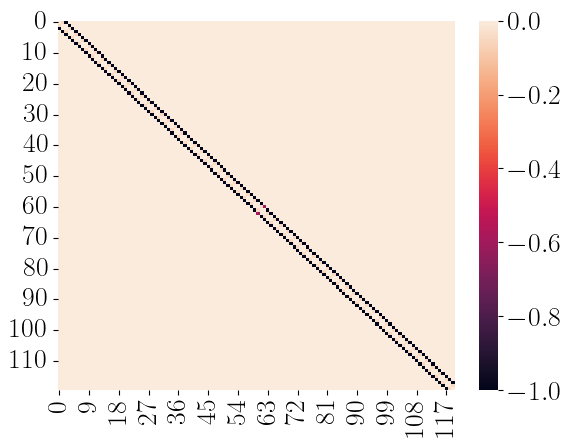

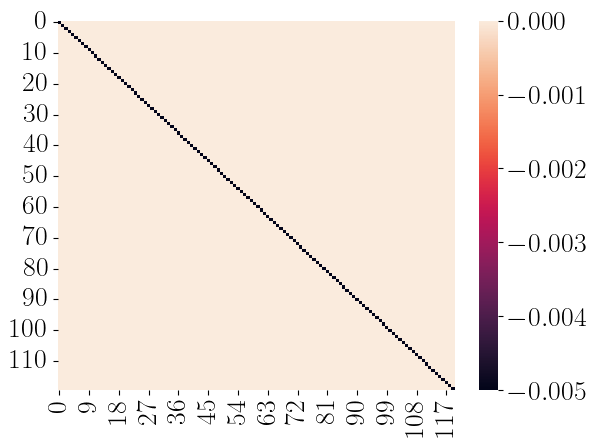

In [185]:
H_dissipative, _ = create_hamiltonians(L_qpc, t, bond_index, gamma)
# Matrix withour dissipation
H_interact, Hdeco = create_hamiltonians(L_qpc, t, bond_index, 0)


plt.figure()
sns.heatmap(H_dissipative.real)

plt.figure()
sns.heatmap(H_dissipative.imag)

In [186]:
# Calculate the energies and eigenvectors
energies_gamma, vecs_gamma = np.linalg.eig(H_dissipative)
vecs_gamma = vecs_gamma/ np.linalg.norm(vecs_gamma, axis=0)

energies_int, vecs_int = np.linalg.eig(H_interact)
vecs_int = vecs_int/ np.linalg.norm(vecs_int, axis=0)

energies_free, vecs_free = np.linalg.eig(Hdeco)
vecs_free = vecs_free/ np.linalg.norm(vecs_free, axis=0)


## Sort into bands

First for the free casew because we use it to sort the other 2

In [187]:
# sort the free evectros into bands according to their projection
mindices, pindices = sort_by_projection(energies_free,vecs_free, Psym)

# minus band
free_energies_m = energies_free[mindices]
free_states_m = vecs_free[:,mindices]
# sort by magnitude
free_energies_m, free_states_m = mag_sort(free_energies_m, free_states_m)

# plus band
free_energies_p = energies_free[pindices]
free_states_p = vecs_free[:,pindices]
# sort by magnitude
free_energies_p, free_states_p = mag_sort(free_energies_p, free_states_p)


For the non-dissipative interactive case

In [188]:
# sort by their overlaps with the free, nondissipative case
sorted_indices, over_matrix = sort_by_overlap_matrix(energies_int, vecs_free,vecs_int)
sorted_e = energies_int[sorted_indices]
sorted_vecs = vecs_int[:,sorted_indices]
# separate into bands and sort by magnitude
# minus band
int_energies_m = sorted_e[mindices]
int_states_m = sorted_vecs[:,mindices]
int_energies_m, int_states_m = mag_sort(int_energies_m, int_states_m)
# plus
int_energies_p = sorted_e[pindices]
int_states_p = sorted_vecs[:,pindices]
int_energies_p, int_states_p = mag_sort(int_energies_p, int_states_p)

For the dissipative interactive one

In [189]:
# sort by their overlaps with the free, nondissipative case
sorted_indices, over_matrix = sort_by_overlap_matrix(energies_gamma, vecs_free,vecs_gamma)
sorted_e = energies_gamma[sorted_indices]
sorted_vecs = vecs_gamma[:,sorted_indices]
# separate into bands and sort by magnitude
# minus band
gamma_energies_m = sorted_e[mindices]
gamma_states_m = sorted_vecs[:,mindices]
gamma_energies_m, int_states_m = mag_sort(gamma_energies_m, gamma_states_m)
# plus
gamma_energies_p = sorted_e[pindices]
gamma_states_p = sorted_vecs[:,pindices]
gamma_energies_p, gamma_states_p = mag_sort(gamma_energies_p, gamma_states_p)

# Broadening of the DOS

for each energy band

In [206]:
def get_spectral(Energies, Op = 10**(-6)):
    # calculates the spectral function of th hamiltonian Ham with infinithesimal Op for
    # regularization
    E_arr = np.linspace(min(Energies.real), max(Energies.real), 9000).real
    
    G_list = [] 
    for i in range(0,len(E_arr)):
        # I put the Op above purely for regularizing the result
        Gn = np.sum(1/(E_arr[i] - Energies + 1j*Op))
        G_list.append(Gn)
    # the boundaries frow way too fast because of the delta so we take them out
    
    return E_arr[1:-1] , -2*np.imag(G_list[1:-1])
    

In [207]:
e_arr, spectral_free = get_spectral( energies_free)
_, spectral_int = get_spectral(energies_int)
_, spectral_gamma = get_spectral(energies_gamma)


(-0.6, 20.0)

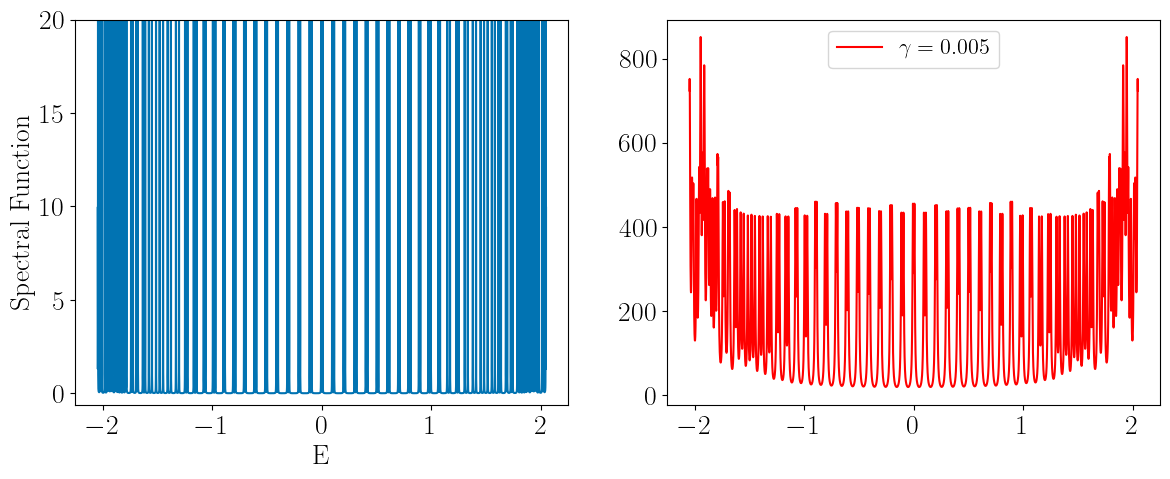

In [215]:
fig, ax = plt.subplots(1,2, figsize=(2*bwidth, bheight))
ax[0].plot(e_arr, spectral_int )
ax[1].plot(e_arr, spectral_gamma, c="red", label = r"$\gamma={}$".format(gamma) )

ax[1].legend()
ax[0].set_xlabel("E")
ax[0].set_ylabel("Spectral Function")
ax[0].set_ylim(-0.6,20)

